In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import shap
from pycaret.regression import *
from pycaret.utils.generic import check_metric
import itertools
import scipy.interpolate

# データファイルをpandasデータフレームで読み込む
file_path = 'boston_dataset.csv'
df = pd.read_csv(
    file_path, # ファイルパス
    #names = column_names, # 列名を指定
    #na_values ='?', # ?は欠損値として読み込む
    #comment = '\t', # TAB以降右はスキップ 
    #sep = ' ', # 空白行を区切りとする
    #skipinitialspace = True, # カンマの後の空白をスキップ  
    #skiprows = [1, 2] # 飛ばしたい行をリストで指定 
    #header = 0, # ヘッダー行を指定
    #nrows = 5, # 読み込む行数
    encoding = 'utf-8', # 'utf-8' 'shift-jis' 'cp932'
) 
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [2]:
# 欠損値の確認
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64

In [3]:
# # 欠損値のある行を必要であれば削除する
# df = df.dropna(axis = 0)
# df = df.dropna(subset = ['特定の列名'])
# df

In [4]:
# カラム名（列名）をリストで抽出
col_list = list(df.columns)
col_list

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT',
 'PRICE']

In [5]:
# 目的変数
targetY = 'PRICE'

# 説明変数をリスト化
x_name_list = col_list.copy()
x_name_list.remove(targetY)
x_name_list

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

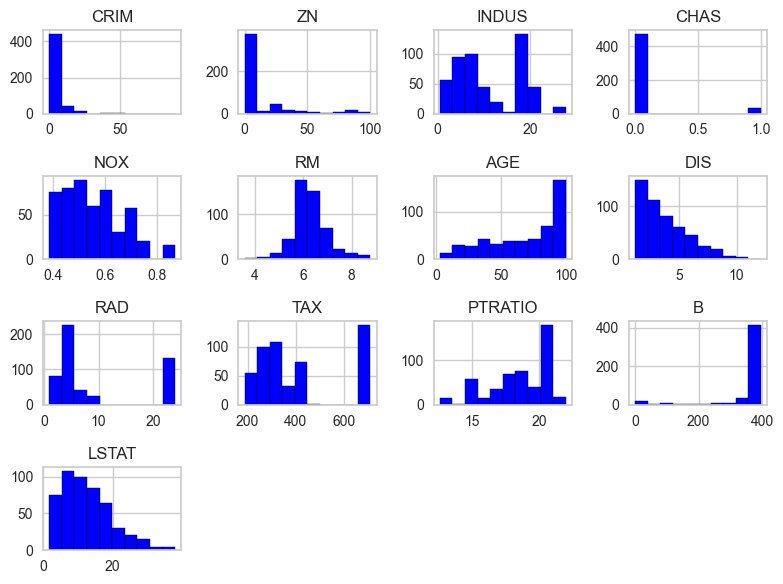

In [6]:
# ヒストグラム
# 入力データの偏りを分布により確認する
df_x = df[x_name_list]

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
df_x.hist(
    ax = ax,
    color = 'blue',
    grid = True,
    edgecolor = 'black',
)
plt.tight_layout()
plt.show()

     PRICE
0     24.0
1     21.6
2     34.7
3     33.4
4     36.2
..     ...
501   22.4
502   20.6
503   23.9
504   22.0
505   11.9

[506 rows x 1 columns]


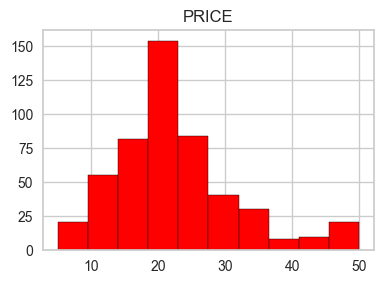

In [7]:
# ヒストグラム
# 出力データの飛び値の有無を確認する
df_y = df[[targetY]]
print(df_y)

fig = plt.figure(figsize=(4,3))
ax = fig.gca()
df_y.hist(
    ax = ax,
    color = 'red',
    grid = True,
    edgecolor = 'black',
)
plt.tight_layout()
plt.show()

In [8]:
# 基本統計量
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


In [9]:
# # 飛び値がある場合に除去する。四分位範囲により判定
# def remove_outliers_func(df_in, column_name):
#     q1 = df_in[column_name].quantile(0.25)
#     q3 = df_in[column_name].quantile(0.75)
#     iqr = q3 - q1 # 四分位範囲 Interquartile range(IQR)
#     print('IQR -> ', iqr)
#     low_line = q1 - 1.5 * iqr
#     high_line = q3 + 1.5 * iqr
#     df_out = df_in.loc[(df_in[column_name] > low_line) & 
#                        (df_in[column_name] < high_line)]
#     return df_out

# DF = remove_outliers_func(df, targetY)

DF = df.copy()
DF

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [10]:
# PyCaret用のデータセット生成（前処理）
from pycaret.regression import *
set_data = setup(
    data = DF,
    normalize = True, # 標準化するかどうか
    normalize_method = 'zscore', # 標準化'zscore' 正規化'minmax'
                                # 絶対値を1'maxabs' ロバスト'robust
    #ignore_features = ['ZN', 'CHAS', B'],
    train_size = 0.75, # 訓練データの割合
    session_id = 1, # ランダムシード
    target = targetY, # 目的変数
    #categorical_features=['列名'], # カテゴリ型を指定する場合               
    #numeric_features = ['列名'], # 数値型を指定する場合
    #remove_outliers = False, # 外れ値の除去
    #outliers_threshold = 0.05, # 0.05の場合、分布の両端裾の0.025%を除去
    #remove_multicollinearity = False, # マルチコ（多重共線性）除去
    #multicollinearity_threshold = 0.9, # 強い相関のある説明変数の片方を削除する
    #create_clusters = False, # クラスタリングにより新規特徴量を作成するかどうか
    #cluster_iter = 20, # default 20
    #polynomial_features = False, # 交互作用項を作成するか（新規特徴量）
    #trigonometry_features = False # 三角関数で作成するか
    #polynomial_degree = 2, # ↑次数で作成するか。[1, a, b, a^2, ab, b^2]
    #polynomial_threshold = 0.1, # 特徴量を残す判定しきい値
    #feature_interaction = False, # 交互作用（a * b）
    #feature_ratio = False, # 交互作用（a / b）
    #interaction_threshold = 0.01, # 特徴量を残す判定しきい値
    #pca = False, # 主成分分析による次元削減
    #pca_method = 'linear', # 'linear' 'kernel' 'incremental'
    #pca_components = 0.99, # 残す特徴量数。int型では数を指定。float型は割合
)

,Description,Value
0,Session id,1
1,Target,PRICE
2,Target type,Regression
3,Original data shape,"(506, 14)"
4,Transformed data shape,"(506, 14)"
5,Transformed train set shape,"(379, 14)"
6,Transformed test set shape,"(127, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


379


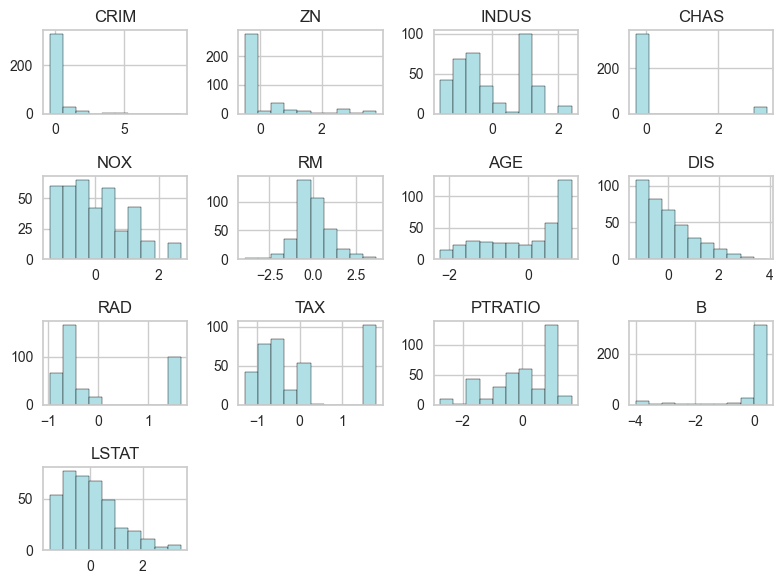

In [11]:
# 訓練データの分布を確認
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
train_x_df = get_config('X_train_transformed')
print(len(train_x_df))
train_x_df.hist(
    ax = ax,
    color = 'powderblue',
    grid = True,
    edgecolor = 'black',
)
plt.tight_layout()
plt.show()

127


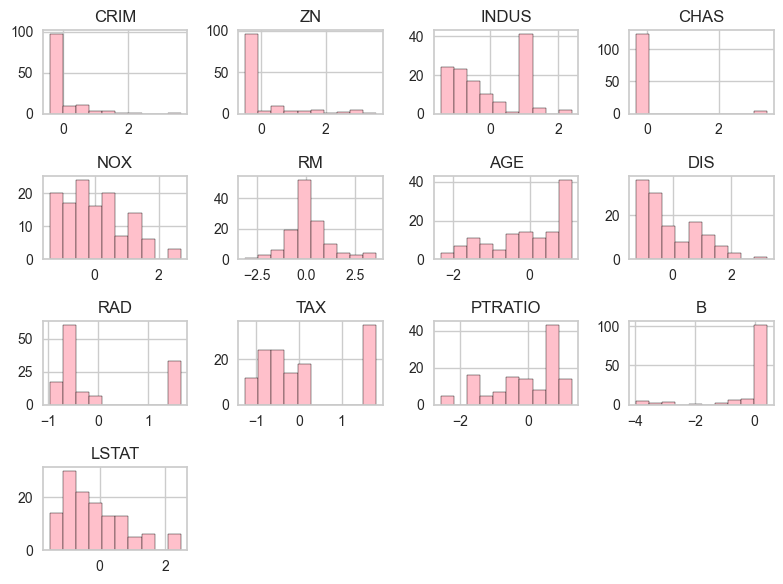

In [12]:
# テストデータの分布を確認
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

test_x_df = get_config('X_test_transformed')
print(len(test_x_df))
test_x_df.hist(
    ax = ax,
    color = 'pink',
    grid = True,
    edgecolor = 'black',
)
plt.tight_layout()
plt.show()

In [13]:
# モデルを比較してトップ5のモデルを抽出
top3 = compare_models(n_select = 3, sort = 'MAE') # R2, MAE, MSE, RMSE, R2, RMSLE, MAPE 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.9759,8.8470,2.8860,0.8857,0.1318,0.0999,0.5330
gbr,Gradient Boosting Regressor,2.1535,9.3179,2.9890,0.8771,0.1451,0.1134,0.3640
lightgbm,Light Gradient Boosting Machine,2.1860,11.4980,3.2565,0.8514,0.1424,0.1091,0.5820
xgboost,Extreme Gradient Boosting,2.2077,10.6240,3.1844,0.8578,0.1479,0.1124,0.3560
rf,Random Forest Regressor,2.2362,10.6029,3.1679,0.8599,0.1419,0.1122,0.3740
et,Extra Trees Regressor,2.2368,11.9086,3.3088,0.8467,0.1432,0.1113,0.4020
ada,AdaBoost Regressor,2.7736,15.4432,3.8067,0.8014,0.1762,0.1467,0.3850
dt,Decision Tree Regressor,2.9481,16.9572,4.0483,0.7678,0.1934,0.1519,0.3620
knn,K Neighbors Regressor,3.0090,23.7792,4.6514,0.7121,0.1842,0.1380,0.3640
huber,Huber Regressor,3.1785,26.5680,4.9411,0.6633,0.2451,0.1539,0.3530


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

In [14]:
# 各モデルのハイパーパラメータをデフォルト範囲で自動調整する
tuned_top3 = [tune_model(i) for i in top3]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1441,7.9917,2.8270,0.8564,0.1354,0.1083
1,2.6579,17.7625,4.2146,0.8138,0.1623,0.1135
2,1.8996,7.7205,2.7786,0.8747,0.0949,0.0822
3,2.8782,15.9567,3.9946,0.8117,0.1734,0.1421
4,1.6963,5.5362,2.3529,0.8976,0.1639,0.1278
5,2.3936,10.3078,3.2106,0.8520,0.1452,0.1209
6,2.1274,10.4456,3.2320,0.8466,0.1323,0.1005
7,2.6295,16.6665,4.0825,0.8702,0.1562,0.1107
8,2.3296,14.8475,3.8532,0.8263,0.1605,0.1164


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1489,9.4590,3.0756,0.8300,0.1355,0.1061
1,2.5213,15.8586,3.9823,0.8337,0.1649,0.1088
2,1.5333,4.6471,2.1557,0.9246,0.0816,0.0692
3,2.3303,11.1568,3.3402,0.8683,0.1572,0.1200
4,1.8180,5.0861,2.2552,0.9059,0.1474,0.1271
5,2.0957,7.4417,2.7279,0.8931,0.1261,0.1053
6,2.1888,10.6109,3.2574,0.8442,0.1260,0.1002
7,2.1621,10.1524,3.1863,0.9209,0.1442,0.0997
8,2.2762,16.5289,4.0656,0.8067,0.1703,0.1169


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.4284,12.1491,3.4856,0.7817,0.1514,0.1204
1,3.3650,30.3958,5.5132,0.6813,0.1958,0.1405
2,1.9091,6.4735,2.5443,0.8949,0.1053,0.0907
3,2.6113,11.2805,3.3586,0.8669,0.1557,0.1316
4,1.8402,5.5384,2.3534,0.8976,0.1645,0.1341
5,2.5373,10.7421,3.2775,0.8457,0.1622,0.1388
6,2.3361,10.4020,3.2252,0.8473,0.1246,0.1078
7,2.4517,12.1645,3.4878,0.9052,0.1495,0.1085
8,3.1827,21.9949,4.6899,0.7427,0.2132,0.1708


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [15]:
# ベスト回帰モデルを自動で選定する
best = automl(optimize = 'MAE')

# モデルをファイナライズする（テストデータを含めて学習）
final_best_model = finalize_model(best)

# テストデータで予測精度の確認
predict_best_df = predict_model(final_best_model)
predict_best_df

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.9890,1.5648,1.2509,0.9842,0.0683,0.0532


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,prediction_label
307,0.04932,33.0,2.18,0.0,0.472,6.849,70.300003,3.1827,7.0,222.0,18.400000,396.899994,7.530000,28.200001,29.797222
343,0.02543,55.0,3.78,0.0,0.484,6.696,56.400002,5.7321,5.0,370.0,17.600000,396.899994,7.180000,23.900000,27.243898
47,0.22927,0.0,6.91,0.0,0.448,6.030,85.500000,5.6894,3.0,233.0,17.900000,392.739990,18.799999,16.600000,17.652045
67,0.05789,12.5,6.07,0.0,0.409,5.878,21.400000,6.4980,4.0,345.0,18.900000,396.209991,8.100000,22.000000,21.577045
362,3.67822,0.0,18.10,0.0,0.770,5.362,96.199997,2.1036,24.0,666.0,20.200001,380.790009,10.190000,20.799999,22.000283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,0.12744,0.0,6.91,0.0,0.448,6.770,2.900000,5.7209,3.0,233.0,17.900000,385.410004,4.840000,26.600000,28.946422
361,3.83684,0.0,18.10,0.0,0.770,6.251,91.099998,2.2955,24.0,666.0,20.200001,350.649994,14.190000,19.900000,19.373020
289,0.04297,52.5,5.32,0.0,0.405,6.565,22.900000,7.3172,6.0,293.0,16.600000,371.720001,9.510000,24.799999,25.381162
498,0.23912,0.0,9.69,0.0,0.585,6.019,65.300003,2.4091,6.0,391.0,19.200001,396.899994,12.920000,21.200001,21.279606


In [16]:
# リッジ回帰モデル（線形回帰モデル）
reg = create_model('ridge')

# スタック合成回帰モデル
stacker = stack_models(estimator_list = [reg],
                       meta_model = best,
                       choose_better = True,
                       optimize = 'MAE')

# モデルをファイナライズする（テストデータを含めて学習）
final_stacked_model = finalize_model(stacker)

# テストデータで予測精度の確認
predict_stacer_df = predict_model(final_stacked_model)
predict_stacer_df

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.1157,20.8017,4.5609,0.6263,0.1845,0.1428
1,4.0107,45.4797,6.7439,0.5232,0.3225,0.1635
2,2.5372,11.1544,3.3398,0.8189,0.1488,0.1280
3,3.3679,19.1834,4.3799,0.7736,0.2049,0.1765
4,3.4181,17.8397,4.2237,0.6701,0.4129,0.2227
5,3.0059,16.9723,4.1197,0.7562,0.2347,0.1949
6,3.6710,32.4693,5.6982,0.5233,0.2140,0.1582
7,4.4089,39.3729,6.2748,0.6933,0.1981,0.1630
8,3.5518,33.1952,5.7615,0.6117,0.2374,0.1594


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1614,9.9117,3.1483,0.8219,0.1369,0.1032
1,2.4888,14.5959,3.8205,0.8470,0.1603,0.1117
2,1.5146,4.4156,2.1013,0.9283,0.0818,0.0686
3,2.5133,11.6144,3.4080,0.8629,0.1482,0.1219
4,1.3270,2.9064,1.7048,0.9463,0.1127,0.0910
5,2.2864,9.1206,3.0200,0.8690,0.1427,0.1164
6,2.0151,11.0832,3.3291,0.8373,0.1282,0.0920
7,2.2752,11.5630,3.4004,0.9099,0.1413,0.0999
8,2.3316,14.9091,3.8612,0.8256,0.1555,0.1119


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,0.9626,1.4874,1.2196,0.9850,0.0622,0.0496


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,prediction_label
307,0.04932,33.0,2.18,0.0,0.472,6.849,70.300003,3.1827,7.0,222.0,18.400000,396.899994,7.530000,28.200001,29.055571
343,0.02543,55.0,3.78,0.0,0.484,6.696,56.400002,5.7321,5.0,370.0,17.600000,396.899994,7.180000,23.900000,25.386787
47,0.22927,0.0,6.91,0.0,0.448,6.030,85.500000,5.6894,3.0,233.0,17.900000,392.739990,18.799999,16.600000,17.594802
67,0.05789,12.5,6.07,0.0,0.409,5.878,21.400000,6.4980,4.0,345.0,18.900000,396.209991,8.100000,22.000000,21.859757
362,3.67822,0.0,18.10,0.0,0.770,5.362,96.199997,2.1036,24.0,666.0,20.200001,380.790009,10.190000,20.799999,21.127142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,0.12744,0.0,6.91,0.0,0.448,6.770,2.900000,5.7209,3.0,233.0,17.900000,385.410004,4.840000,26.600000,28.335780
361,3.83684,0.0,18.10,0.0,0.770,6.251,91.099998,2.2955,24.0,666.0,20.200001,350.649994,14.190000,19.900000,19.374667
289,0.04297,52.5,5.32,0.0,0.405,6.565,22.900000,7.3172,6.0,293.0,16.600000,371.720001,9.510000,24.799999,25.178536
498,0.23912,0.0,9.69,0.0,0.585,6.019,65.300003,2.4091,6.0,391.0,19.200001,396.899994,12.920000,21.200001,20.755307


In [17]:
# ベスト回帰モデルとスタッキング回帰モデルの予測精度を比較する
metric_list = ['MAE', 'MSE', 'RMSE', 'RMSLE', 'R2']
for metric in metric_list:
    val_best = check_metric(predict_best_df[targetY], predict_best_df['prediction_label'], metric)
    val_stacker = check_metric(predict_stacer_df[targetY], predict_stacer_df['prediction_label'], metric)
    print(metric, round(val_best, 3), round(val_stacker, 3))
    if metric == 'R2':
        if (val_best >= val_stacker) and ('Ridge' in str(final_best_model)):
            print('selected best_model')
            val = val_best
            final_model = final_best_model
        else:
            print('selected stacked_model')
            val = val_stacker
            final_model = final_stacked_model
final_model

MAE 0.989 0.963
MSE 1.565 1.487
RMSE 1.251 1.22
RMSLE 0.068 0.062
R2 0.984 0.985
selected stacked_model


Pipeline(memory=FastMemory(location=C:\Users\hkosa\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['CRIM', 'ZN', 'INDUS', 'CHAS',
                                             'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                                             'TAX', 'PTRATIO', 'B', 'LSTAT'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 StackingRegressor(cv=5,
                                   estimators=[('Ridge Regression',
                                                Ridge(random_state=1))],
                                   final_estimator=<catboost.core.CatBoostRegressor object at 0x00000217DC7B90F0>,
                                   n_jobs=-1, passthrough=True))])

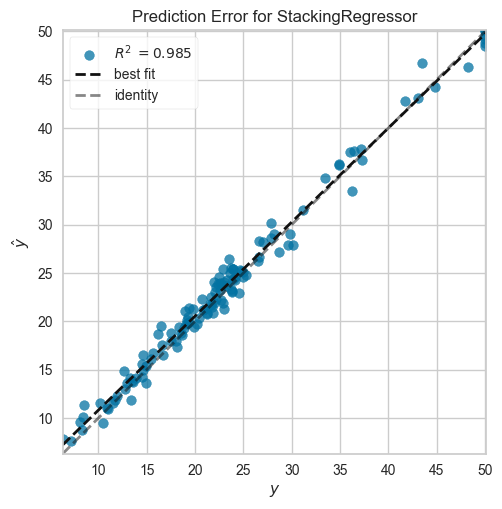

In [18]:
# 作成した回帰モデルの傾向のあてはまり度合いの確認
plot_model(final_model, plot = 'error', save = False)
#os.rename('Prediction Error.png', f'final_model_{targetY}_Prediction_Error.png')

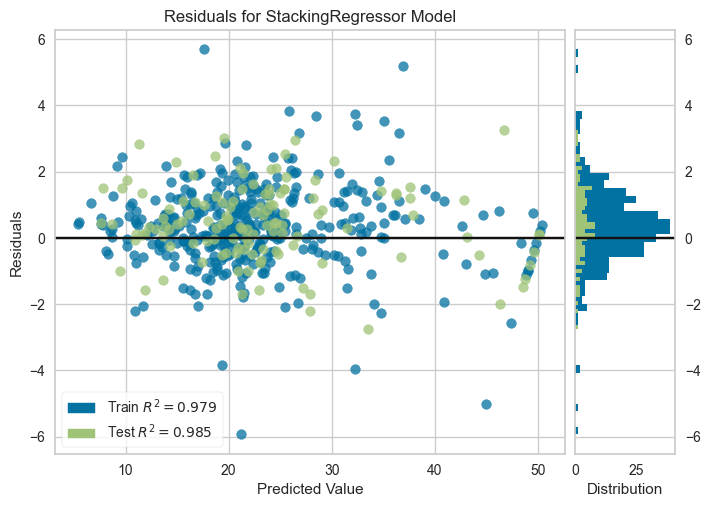

In [19]:
# 作成した回帰モデルの絶対値のずれ度合いの確認
plot_model(final_model, plot = 'residuals', save = False)
#os.rename('Residuals.png', f'final_model_{targetY}_Residuals.png')

In [20]:
# シャープレイ値でデータを可視化してゆく
DF_X = DF.drop(targetY, axis = 1)
explainer = shap.Explainer(final_model.predict, DF_X)
shap_values = explainer(DF_X)
len(shap_values)

Permutation explainer: 507it [07:05,  1.17it/s]                                                                        


506

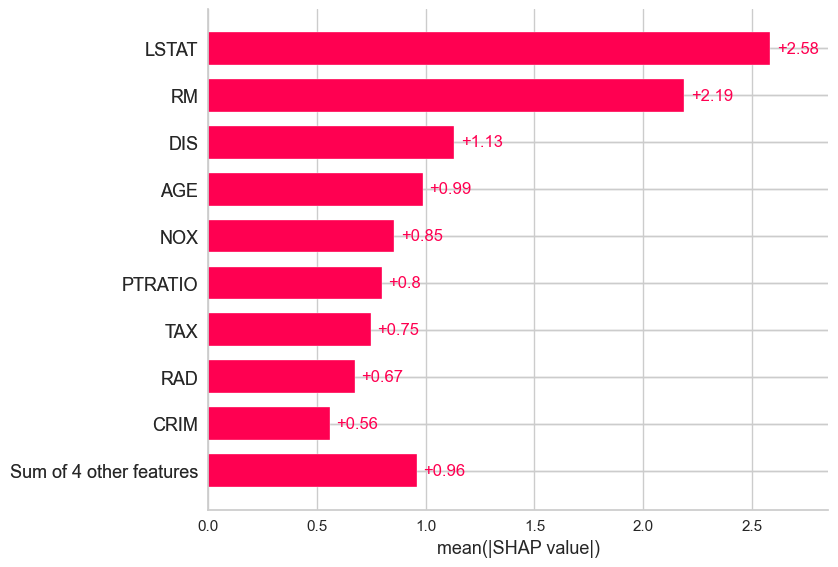

In [21]:
# シャープレイ値による特徴量のランキング（棒グラフ）
shap.plots.bar(shap_values,
               #max_display = 3,
              )

In [22]:
# 特徴量のランキングをpandasデータフレームで取得する
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(DF_X.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
feature_importance

,col_name,feature_importance_vals
12,LSTAT,2.584699
5,RM,2.188872
7,DIS,1.132432
6,AGE,0.986455
4,NOX,0.854609
10,PTRATIO,0.798819
9,TAX,0.747805
8,RAD,0.673701
0,CRIM,0.558145
11,B,0.406352


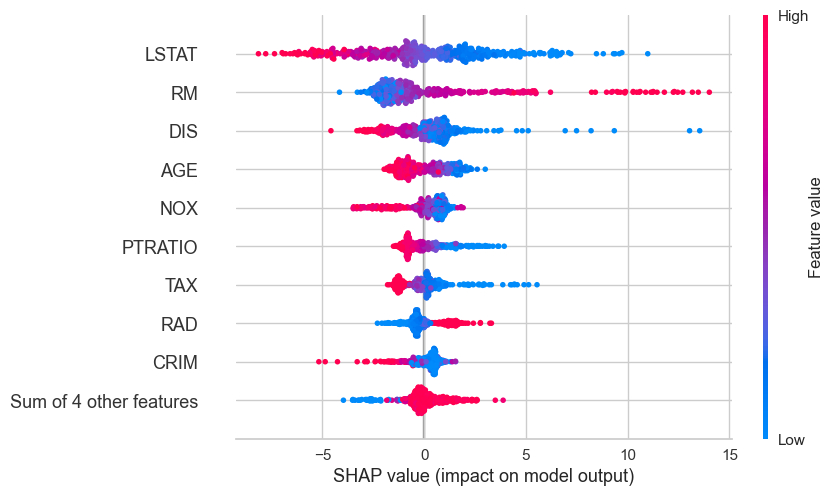

In [23]:
# シャープレイ値による特徴量のランキング
shap.plots.beeswarm(shap_values,
                     #color = plt.get_cmap("cool"),
                    )

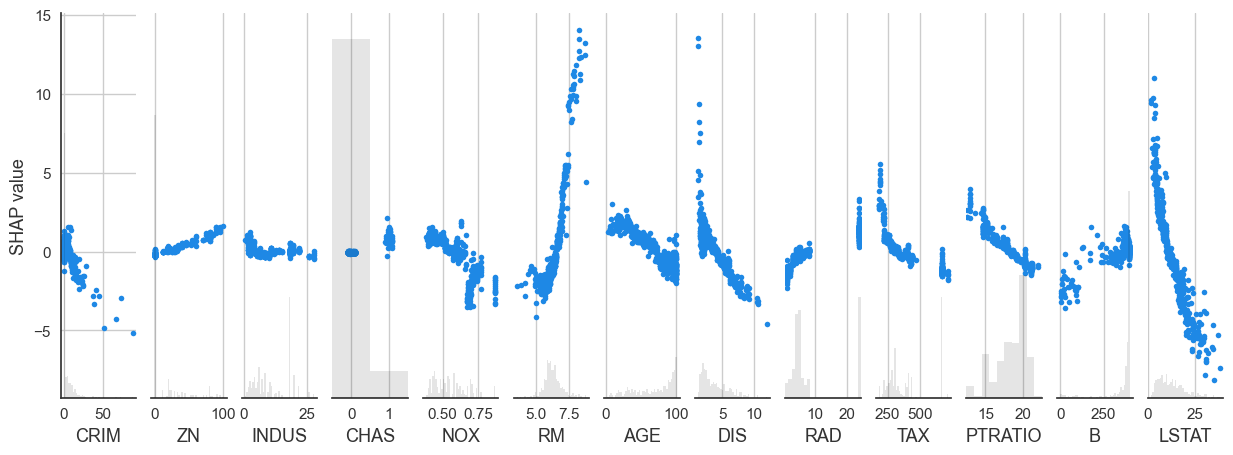

In [24]:
# シャープレイ値による特徴量の主効果図
shap.plots.scatter(shap_values)

In [25]:
# 最も重要な特徴量（説明変数）を取得する
most_important_feature = list(feature_importance['col_name'])[0]
most_important_feature

'LSTAT'

[ 7  4  8  6  0  9  2 11  5  1  3 10 12]


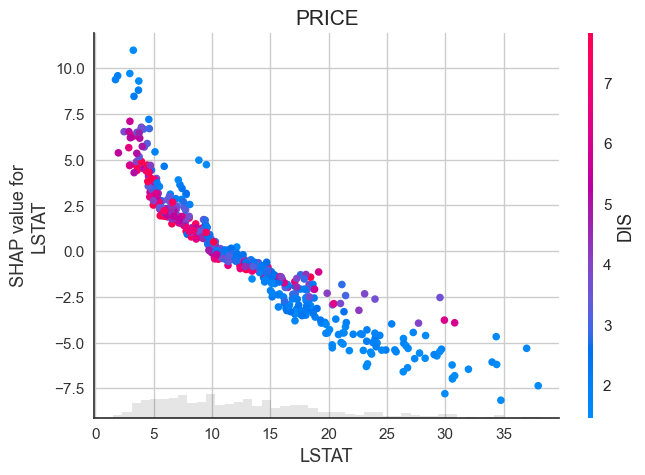

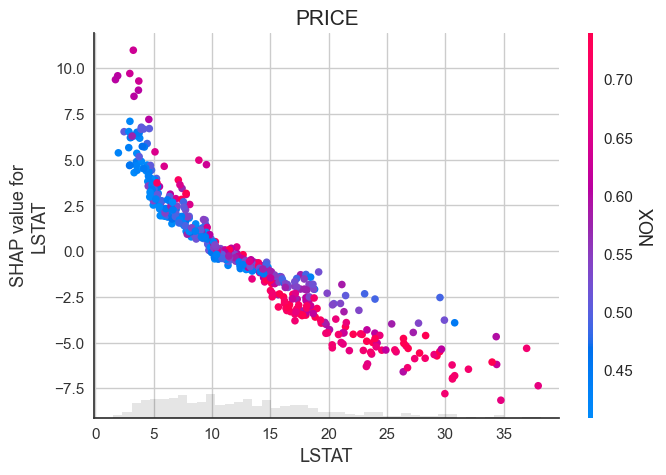

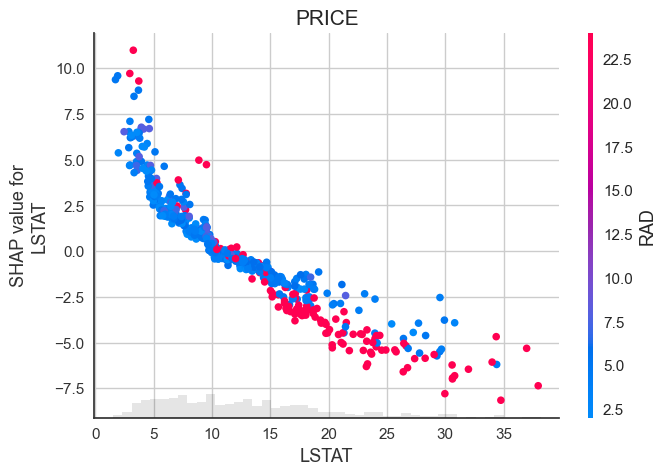

In [26]:
# シャープレイ値による2変数の散布図
inds = shap.utils.potential_interactions(shap_values[:, most_important_feature], shap_values)
print(inds)

inds = shap.utils.potential_interactions(shap_values[:, most_important_feature], shap_values)

for i in range(3):
    shap.plots.scatter(
        shap_values[:,most_important_feature],
        dot_size = 30,
        x_jitter = 0.1,
        #alpha = 0.5,
        color=shap_values[:,inds[i]],
        show = False,
    )
    plt.title(f"{targetY}", fontsize = 15)
    plt.show()    

In [27]:
# 回帰モデルを保存する
model_file_name = f'final_model_{targetY}'
save_model(final_model, model_name = f'final_model_{targetY}')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\hkosa\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['CRIM', 'ZN', 'INDUS', 'CHAS',
                                              'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                                              'TAX', 'PTRATIO', 'B', 'LSTAT'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('actual_estimator',
                  StackingRegressor(cv=5,
                                    estimators=[('Ridge Regression',
                                                 Ridge(random_state=1))],
                                    final_estimator=<catboost.core.CatBoostRegressor objec

In [28]:
# 保存した回帰モデルをロードする
load_reg_model = load_model(model_file_name)
load_reg_model

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\hkosa\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['CRIM', 'ZN', 'INDUS', 'CHAS',
                                             'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                                             'TAX', 'PTRATIO', 'B', 'LSTAT'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 StackingRegressor(cv=5,
                                   estimators=[('Ridge Regression',
                                                Ridge(random_state=1))],
                                   final_estimator=<catboost.core.CatBoostRegressor object at 0x00000217E2EBA3E0>,
                                   n_jobs=-1, passthrough=True))])

In [29]:
# 新しいデータで予測する（ここでは便宜上、元のデータの目的変数の列を削除して使う）
new_df = df.copy()
new_df.drop(targetY, axis = 1, inplace = True)
predict_model(final_model, data = new_df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,prediction_label
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.199997,4.0900,1.0,296.0,15.300000,396.899994,4.98,24.353314
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.900002,4.9671,2.0,242.0,17.799999,396.899994,9.14,21.247702
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.099998,4.9671,2.0,242.0,17.799999,392.829987,4.03,34.371795
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.799999,6.0622,3.0,222.0,18.700001,394.630005,2.94,33.744024
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.200001,6.0622,3.0,222.0,18.700001,396.899994,5.33,35.666091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.099998,2.4786,1.0,273.0,21.000000,391.989990,9.67,22.723560
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.699997,2.2875,1.0,273.0,21.000000,396.899994,9.08,19.206670
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.000000,2.1675,1.0,273.0,21.000000,396.899994,5.64,23.655240
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.300003,2.3889,1.0,273.0,21.000000,393.450012,6.48,22.563421
